#### BurnMan - Step 3 - Build a Planet

Copyright (C) 2012 - 2018 by the BurnMan team, released under the GNU GPL v2 or later.
Released under GPL v2 or later.



For Earth we have well-constrained one-dimensional density models.  This allows us to
calculate pressure as a function of depth.  Furthermore, petrologic data and assumptions
regarding the convective state of the planet allow us to estimate the temperature.

For planets other than Earth we have much less information, and in particular we
know almost nothing about the pressure and temperature in the interior.  Instead, we tend
to have measurements of things like mass, radius, and moment-of-inertia.  We would like
to be able to make a model of the planet's interior that is consistent with those
measurements.

However, there is a difficulty with this.  In order to know the density of the planetary
material, we need to know the pressure and temperature.  In order to know the pressure,
we need to know the gravity profile.  And in order to the the gravity profile, we need
to know the density.  This is a nonlinear problem which requires us to iterate to find
a self-consistent solution.

This example allows the user to define layers of planets of known outer radius and self-
consistently solve for the density, pressure and gravity profiles. The calculation will
iterate until the difference between central pressure calculations are less than 1e-5.
The planet class in BurnMan (../burnman/planet.py) allows users to call multiple
properties of the model planet after calculations, such as the mass of an individual layer,
the total mass of the planet and the moment if inertia. See planets.py for information
on each of the parameters which can be called.

*Uses:*

* :doc:`mineral_database`
* :class:`burnman.planet.Planet`
* :class: `burnman.layer.Layer`

*Demonstrates:*

* setting up a planet
* computing its self-consistent state
* computing various parameters for the planet
* seismic comparison

# Imports

In [18]:
%matplotlib inline
import os,sys

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1,os.path.abspath('./BurnMan_developersversion/'))
import burnman
import burnman.mineral_helpers as helpers

import obspy
from obspy.taup import TauPyModel

# Defining Layers
First, we must define the composition of the planet as individual layers.
A layer is defined by 4 parameters: Name, min_depth, max_depth,and number of slices within the layer.
Separately the composition and the temperature_mode need to set.

In [2]:
radius_planet = 6371.e3
# inner_core
inner_core = burnman.Layer('inner core', radii = np.linspace(0,1220.e3,10))
inner_core.set_material(burnman.minerals.other.Fe_Dewaele())

# The minerals that make up our core do not currently implement the thermal equation of state, so we will set the temperature at 300 K.
inner_core.set_temperature_mode('user-defined',
    300.*np.ones_like(inner_core.radii))

# outer_core
outer_core = burnman.Layer('outer core', radii = np.linspace(1220.e3,3480.e3,10))
outer_core.set_material(burnman.minerals.ICL_2018.EPOC_vinet())
# The minerals that make up our core do not currently implement the thermal equation of state, so we will define the temperature at 300 K.
outer_core.set_temperature_mode('user-defined', 300.*np.ones_like(outer_core.radii))

# Next the Mantle.
lower_mantle = burnman.Layer('lower mantle', radii = np.linspace(3480.e3, 5711.e3, 10))
lower_mantle.set_material(burnman.minerals.SLB_2011.mg_bridgmanite())
lower_mantle.set_temperature_mode('adiabatic')
upper_mantle = burnman.Layer('upper mantle', radii = np.linspace(5711.e3, 6371e3, 10))
upper_mantle.set_material(burnman.minerals.SLB_2011.forsterite())
upper_mantle.set_temperature_mode('adiabatic', temperature_top = 1200.)

# Making a self-consistent planet
Now we stitch the planet together

In [3]:
planet_zog = burnman.Planet('Planet_Zog',
                            [inner_core, outer_core, lower_mantle, upper_mantle],
                            verbose=True)
print(planet_zog)

Planet_Zog consists of 4 layers:
The inner core is made of Fe_Dewaele with user-defined temperatures and self-consistent pressures
The outer core is made of EPOC_vinet with user-defined temperatures and self-consistent pressures
The lower mantle is made of Mg_Perovskite with adiabatic temperatures and self-consistent pressures
The upper mantle is made of Forsterite with adiabatic temperatures and self-consistent pressures



Here we compute its state, this is where all the work gets done. Go BurnMan Go!
(If we were to change composition of one of the layers, we would have to
recompute the state)

In [4]:
planet_zog.make()

Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.5e-01
Iteration 3 maximum relative pressure error: 1.7e-01
Iteration 4 maximum relative pressure error: 6.1e-02
Iteration 5 maximum relative pressure error: 2.1e-02
Iteration 6 maximum relative pressure error: 7.0e-03
Iteration 7 maximum relative pressure error: 2.4e-03
Iteration 8 maximum relative pressure error: 8.0e-04
Iteration 9 maximum relative pressure error: 2.7e-04
Iteration 10 maximum relative pressure error: 9.1e-05
Iteration 11 maximum relative pressure error: 3.1e-05
Iteration 12 maximum relative pressure error: 1.0e-05
Iteration 13 maximum relative pressure error: 3.5e-06


# Showing results
Now we can output the mass of the planet and moment of inertia

In [6]:
print('\nmass/Earth= {0:.3f}, moment of inertia factor= {1:.4f}'.format(planet_zog.mass / 5.97e24,
                                                                      planet_zog.moment_of_inertia_factor))


mass/Earth= 0.986, moment of inertia factor= 0.3274


Or the mass of the individual layers

In [8]:
for layer in planet_zog.layers:
    print('{0} mass fraction of planet {1:.3f}'.format(layer.name, layer.mass / planet_zog.mass))
print('')

inner core mass fraction of planet 0.018
outer core mass fraction of planet 0.315
lower mantle mass fraction of planet 0.492
upper mantle mass fraction of planet 0.174



Let's get PREM to compare everything to as we are trying
to imitate Earth

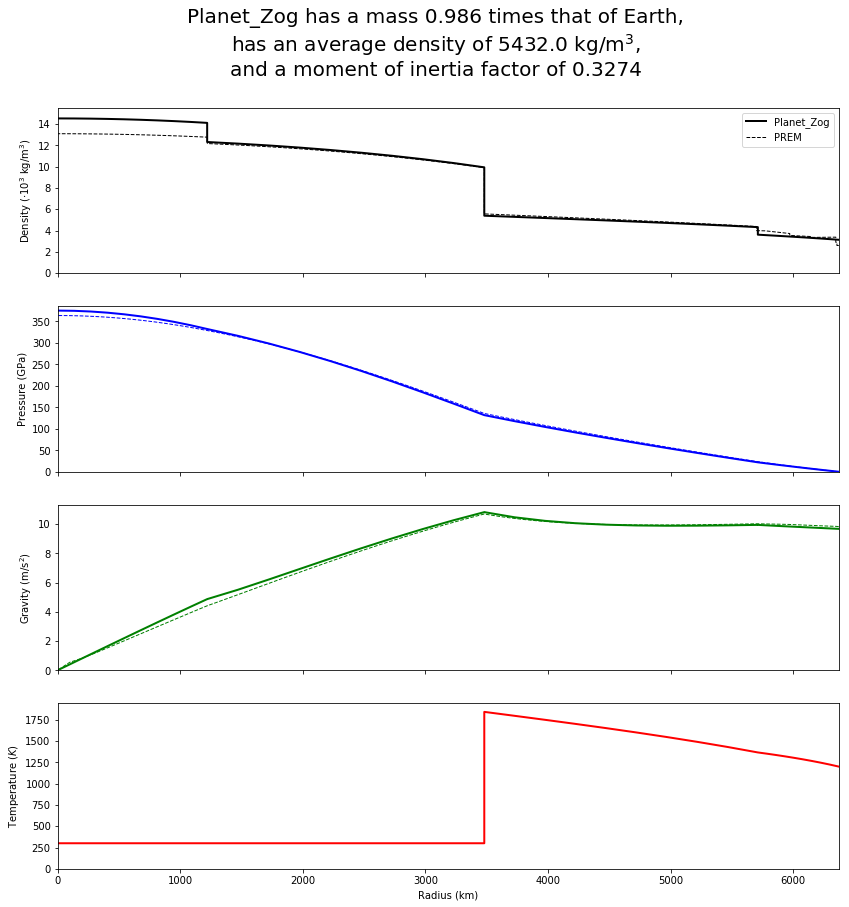

In [21]:
prem = burnman.seismic.PREM()
premradii = 6371.e3 - prem.internal_depth_list()
premdensity, prempressure, premgravity,premvs,premvp = prem.evaluate(
    ['density', 'pressure', 'gravity', 'v_s','v_p'])


figure = plt.figure(figsize=(14, 14))
figure.suptitle(
    '{0} has a mass {1:.3f} times that of Earth,\n'
    'has an average density of {2:.1f} kg/m$^3$,\n'
    'and a moment of inertia factor of {3:.4f}'.format(
        planet_zog.name,
        planet_zog.mass/5.97e24,
        planet_zog.average_density,
        planet_zog.moment_of_inertia_factor),
        fontsize=20)

ax = [figure.add_subplot(4, 1, i) for i in range(1, 5)]

ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3, 'k', linewidth=2.,
           label=planet_zog.name)
ax[0].plot( premradii / 1.e3, premdensity / 1.e3, '--k', linewidth=1.,
    label='PREM')
ax[0].set_ylim(0., (max(planet_zog.density) / 1.e3) + 1.)
ax[0].set_ylabel('Density ($\cdot 10^3$ kg/m$^3$)')
ax[0].legend()

# Make a subplot showing the calculated pressure profile
ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9, 'b', linewidth=2.)
ax[1].plot(premradii / 1.e3, prempressure / 1.e9, '--b', linewidth=1.)
ax[1].set_ylim(0., (max(planet_zog.pressure) / 1e9) + 10.)
ax[1].set_ylabel('Pressure (GPa)')

# Make a subplot showing the calculated gravity profile
ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity, 'g', linewidth=2.)
ax[2].plot(premradii / 1.e3, premgravity, '--g', linewidth=1.)
ax[2].set_ylabel('Gravity (m/s$^2)$')
ax[2].set_ylim(0., max(planet_zog.gravity) + 0.5)

# Make a subplot showing the calculated temperature profile
ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature, 'r', linewidth=2.)
ax[3].set_ylabel('Temperature ($K$)')
ax[3].set_xlabel('Radius (km)')
ax[3].set_ylim(0., max(planet_zog.temperature) + 100)

for i in range(3):
    ax[i].set_xticklabels([])
for i in range(4):
    ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)

    

# Plotting ray paths and predicted travel times

First we need to build the correct input file for obspy.

In [23]:
# Write out a tvel file
burnman.output_seismo.write_tvel_file(planet_zog, filename=planet_zog.name + '.tvel')
# Build a taup_model for Obspy
obspy.taup.taup_create.build_taup_model(
            "./" + planet_zog.name + ".tvel", ".")

Building obspy.taup model for './Planet_Zog.tvel' ...


Arrivals to plot, some random examples of phase names to use ("P","S", "PcP", "Sdiff", "SKS", "PKIKP") <br>
Phase naming in obspy.taup is explained at
https://docs.obspy.org/packages/obspy.taup.html

There were rays for all but the following epicentral distances:
 [120.0, 240.0]
There were rays for all but the following epicentral distances:
 []


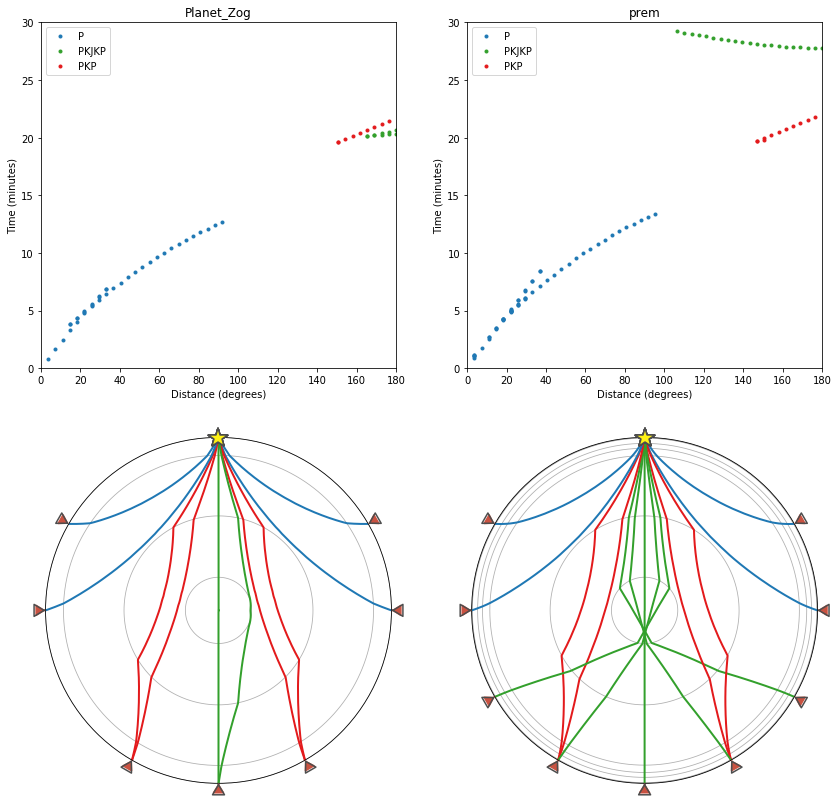

In [26]:
phase_list = ["P", "PKP", "PKJKP"]
source_depth = 10 # in km
min_degrees = 60 # minimum distance for ray paths
max_degrees = 300 # maximum distance for ray paths
npoints = 9 # number of distances to plot ray paths
ref_model = 'prem' # choice of models available in obpsy, or input an npz file name


# Parameters to zoom on traveltime plot
distmin =0
distmax =180
timemin =0
timemax=30

# Time to plot some predictions using routines from Obspy
plt.figure(figsize=[14, 14])
ax = plt.subplot(2, 2, 1)
# plotting predicted travel times at all distances
obspy.taup.plot_travel_times(
    ax=ax,
    model='./' +
    planet_zog.name +
    '.npz',
    source_depth=source_depth,
    phase_list=phase_list,
    show=False)

plt.xlim([distmin,distmax])
plt.ylim([timemin, timemax])
plt.title(planet_zog.name)
# plotting the same for PREM for reference
ax = plt.subplot(2, 2, 2)
obspy.taup.plot_travel_times(
    ax=ax,
    model=ref_model,
    source_depth=source_depth,
    phase_list=phase_list,
    show=False)
plt.xlim([distmin,distmax])
plt.ylim([timemin, timemax])
# not sure why the grid dissapears on this subplot, reactivate here...
ax.grid()
plt.title(ref_model)
# plotting predicted ray paths every 30 degrees between 60 and 300
# degrees
ax = plt.subplot(2, 2, 3, polar=True)
obspy.taup.plot_ray_paths(
    ax=ax,
    model='./' +
    planet_zog.name +
    '.npz',
    source_depth=source_depth,
    min_degrees=min_degrees,
    max_degrees=max_degrees,
    npoints=npoints,
    phase_list=phase_list,
    verbose=True,
    show=False)
# plotting the same for PREM for reference
ax = plt.subplot(2, 2, 4, polar=True)
obspy.taup.plot_ray_paths(
    ax=ax,
    model=ref_model,
    source_depth=source_depth,
    min_degrees=min_degrees,
    max_degrees=max_degrees,
    npoints=npoints,
    phase_list=phase_list,
    verbose=True)
